<center> <h1>mIA-X 8ª Edición</h1> </center>

<center> <h1>Práctica 9 - Modelos Generativos</h1> </center>

<center> <h1>Javier Langeber Gavilán</h1> </center>

<center> <h1>Ejercicio 3</h1> </center>

---

## Diseña un VAE para generar series de precios de las empresas constituyentes del S&P500

## 1. Carga de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as kt
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as tf
from keras.layers import Dense, Flatten, Reshape, Input
from keras.models import Sequential, Model
from keras.layers.rnn.base_conv_rnn import InputSpec
from keras.losses import MSE

### 2. Importación y tratamiento de datos

In [2]:
sp_data = pd.read_csv('../data/all_stocks_5yr.csv')
sp_data = sp_data.pivot(index = 'date', columns='Name', values='close')
sp_data.dropna(axis=1, inplace=True)

Se visualizan los datos de precios

In [35]:
sp_data.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.12,45.70,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.64,46.08,...,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.89,46.27,...,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.81,46.26,...,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.61,46.54,...,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


Se generan datos de retornos logarítmicos

In [7]:
retornos = np.log(sp_data).diff().dropna(axis=0)
retornos.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.010705,-0.019857,-0.006485,0.010368,-0.011096,-0.002776,-0.004369,-0.003279,-0.012346,0.008281,...,0.002476,-0.001334,-0.003731,-0.000700,0.003762,0.013566,-0.011552,-0.002640,0.002896,0.006334
2013-02-12,0.000448,-0.013227,0.002675,-0.025386,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,...,0.003526,0.003198,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329
2013-02-13,0.002909,0.026963,0.004696,-0.001905,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,...,0.000352,0.005837,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647
2013-02-14,-0.003806,-0.046780,-0.001648,-0.000900,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,...,-0.007062,0.016789,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381
2013-02-15,-0.053681,0.035806,0.002027,-0.013876,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,...,0.015820,-0.008360,-0.001809,-0.002567,-0.007500,-0.006696,0.001564,-0.005780,-0.011844,0.021116


Para comprender mejor el comportamiento de los datos, se muestran las gráficas de los datos de precios y retornos

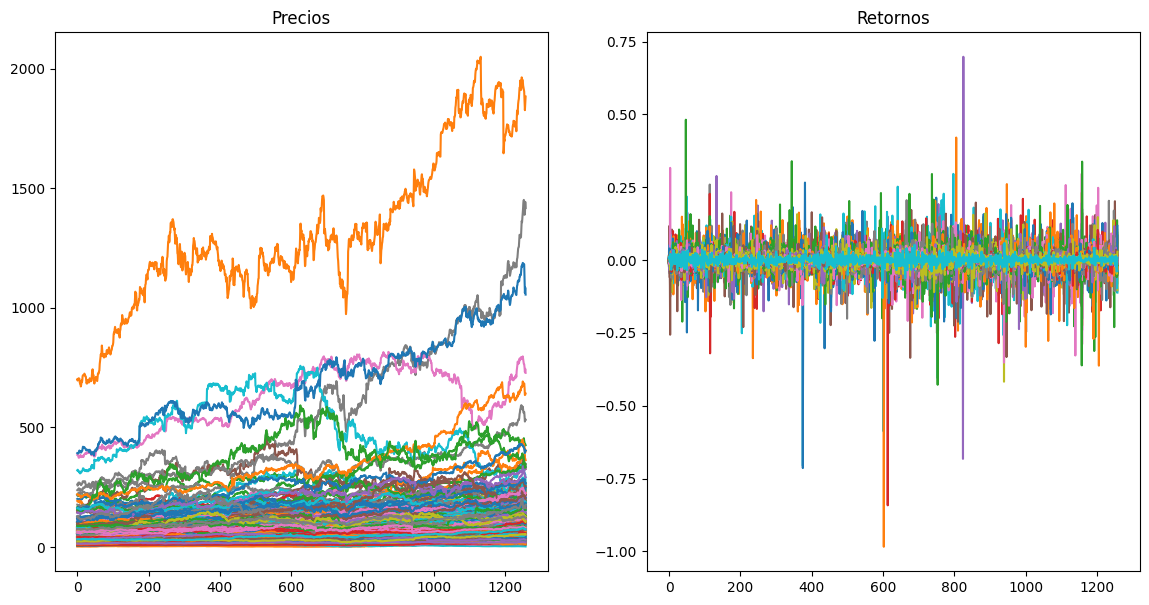

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
ax1.plot(np.array(sp_data));
ax1.title.set_text('Precios')
ax2.plot(np.array(retornos));
ax2.title.set_text('Retornos')

## 3. Generación del VAE

Al igual que se ha realizado en el ejercicio anterior, se va a desarrollar un VAE para la generación de datos. Pero antes de eso, en primer lugar, se preparan los datos con los que se va a aentrenar el VAE, que en este caso se trata del array de retornos de las empresas constituyentes del S&P 500

In [11]:
x_train = np.array(retornos.T)

Una vez preparados los datos, se crean las capas de Sampling y KL

#### 3.1. Capa de Sampling

In [12]:
# Capa de Sampling
from keras.layers import Layer
import tensorflow as tf
class Sampling(Layer):

  def __init__(self):
    super(Sampling, self).__init__()

  def call(self, inputs):
    mu, logstd = inputs
    std = tf.exp(logstd)
    epsilon = tf.random.normal(tf.shape(mu))
    return epsilon * std + mu

In [13]:
mu = Input(shape=2)
logstd = Input(shape=2)
sample = Sampling()([mu, logstd])
sampling_mod = Model([mu, logstd], sample)

### 3.2. Capa KL

In [14]:
class KL(Layer):

  def __init__(self, beta=1):
    self.beta = beta
    super(KL, self).__init__()
    

  def call(self, inputs):
    mu, logstd = inputs 
    kl_loss = 0.5 * (tf.square(mu) + tf.exp(logstd * 2.) - 1 - logstd * 2.)
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    self.add_loss(kl_loss)
    return inputs

In [15]:
mu = Input(shape = 2)
logstd = Input(shape = 2)
mu2, logstd2 = KL()([mu, logstd])
kl_model = Model([mu, logstd], [mu2, logstd2])

In [16]:
kl_model.compile()

### 3.3. AutoEncoder

Una vez desarrolladas las 2 capas auxiliares, se compila en AutoEncoder. Para ello, y siguiendo con el procedimiento del ejercicio anterior, se crea en primer lugar el Encoder.

#### 3.3.1. Encoder

In [64]:
z_dim = 20
h_dim = 100
data_len = retornos.shape[0]

In [65]:
encoder_head = Sequential([
    Dense(h_dim, activation = 'relu'),
])

inp = Input(data_len)
h = encoder_head(inp)
mu = Dense(z_dim)(h)
logstd = Dense(z_dim)(h)


# KL Layer
muout, logstdout = KL()([mu, logstd])

# Sampling Layer
z = Sampling()([muout,logstdout])

In [66]:
encoder_mean = Model(inp, mu)
encoder_sample = Model(inp, z)

In [67]:
encoder_sample.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1258)]       0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 100)          125900      ['input_6[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 20)           2020        ['sequential_4[0][0]']           
                                                                                                  
 dense_7 (Dense)                (None, 20)           2020        ['sequential_4[0][0]']           
                                                                                            

#### 3.3.2. Decoder

Y posteriormente, se crea el Decoder

In [68]:
decoder = Sequential([
    Dense(h_dim, activation='relu', input_shape = (z_dim,)),
    Dense(data_len, activation='tanh')
])

In [69]:
decoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               2100      
                                                                 
 dense_9 (Dense)             (None, 1258)              127058    
                                                                 
Total params: 129,158
Trainable params: 129,158
Non-trainable params: 0
_________________________________________________________________


Una vez generados ambos modelos, se compila el VAE

In [70]:
vae = Sequential([encoder_mean, decoder])
vae.compile(optimizer = 'adam', loss=lambda x,y: MSE(x,y)*data_len)

Antes de entrenar el VAE, se muestra la capacidad que tiene de reconstruir series de precios.

In [71]:
def compare_prices(stock_num):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
    ax1.plot(np.array(sp_data.iloc[:,stock_num]));
    ax1.title.set_text('Serie de precios original')
    ax2.plot(np.exp((vae.predict(x_train[stock_num:stock_num+1])[0]).cumsum())*sp_data.iloc[0,stock_num]);
    ax2.title.set_text('Serie de precios reconstruida')
    return

1/1 [==============================] - 0s 59ms/step


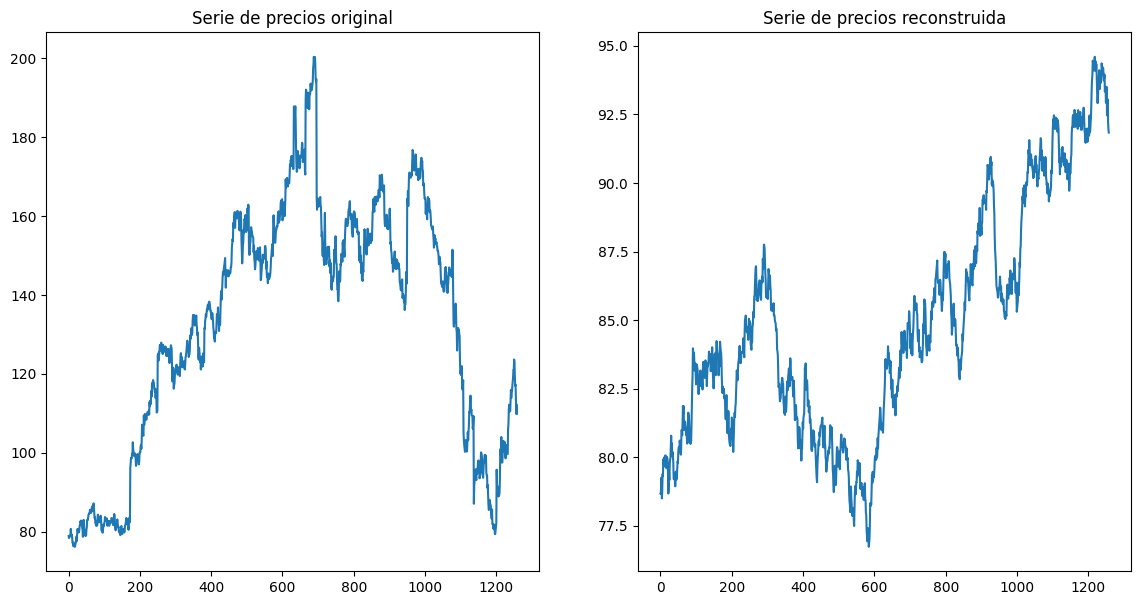

In [72]:
compare_prices(2)

A continuación, se entrena el VAE

In [73]:
n_epochs = 1000
batch_size = 128
history = vae.fit(x_train, x_train, batch_size=batch_size, epochs=n_epochs)

Epoch 1/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.3123
Epoch 2/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2695
Epoch 3/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2527
Epoch 4/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.2441
Epoch 5/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2376
Epoch 6/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2310
Epoch 7/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2256
Epoch 8/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2206
Epoch 9/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2160
Epoch 10/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2115
Epoch 11/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.2076
Epoch 12/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.2038
Epoch 13/1000
4/4 [==============================

Una vez entrenado el modelo, se comprueba que la función de pérdidas ha llegado a un estado estacionario y no es capaz de reducirse más

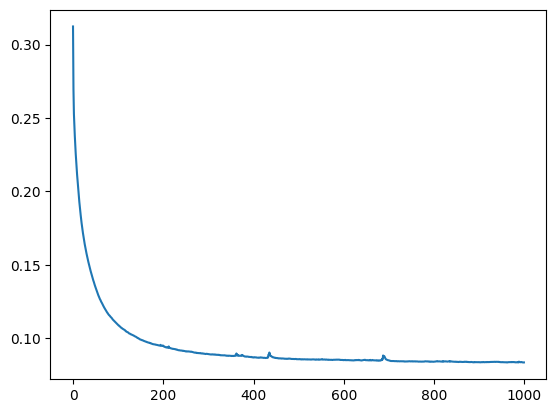

In [74]:
plt.plot(history.history['loss'])

Tras haber entrenado y tras haber comprobado que se ha estabilizado la función de pérdidas, se vuelve a comprobar la capcidad regenerativa del modelo

1/1 [==============================] - 0s 23ms/step


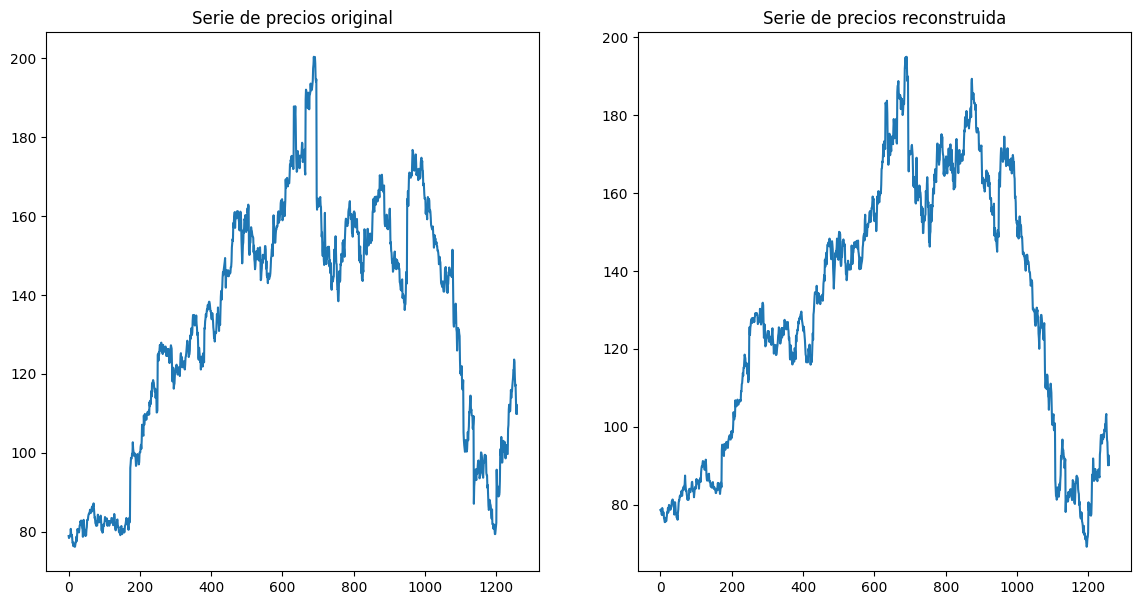

In [75]:
compare_prices(2)

## 4. Generación de nuevas muestras

Tras haber completado el entrenamiento del AutoEncoder, es posible generar nuevas muestras de precios

En priemr lugar, los datos de precios generados deberán partir de los úlitmos datos disponibles, que son los sigueintes

In [76]:
sp_data.tail(2)

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-02-06,68.45,51.18,112.20,163.03,111.20,91.54,58.86,154.69,194.47,88.54,...,37.34,68.99,78.35,58.46,30.85,71.33,80.58,122.30,52.52,73.27
2018-02-07,68.06,51.40,109.93,159.54,113.62,94.22,58.67,155.15,192.34,85.35,...,42.00,66.97,76.94,58.30,31.18,71.79,80.13,120.78,54.02,73.86


A continuación, se puede generar un vector aleatorio de ``z_dim`` dimensiones, que pueda representar el vector en el espacio latente de una muestra de precios generada. Una vez generado ese vecotr simulado en el espacio latente, se puede pasar por el decoder para reconstruir el precio que lo habría generado, obteniendo de este modo una nueva serie de precios.

1/1 [==============================] - 0s 58ms/step


<AxesSubplot: >

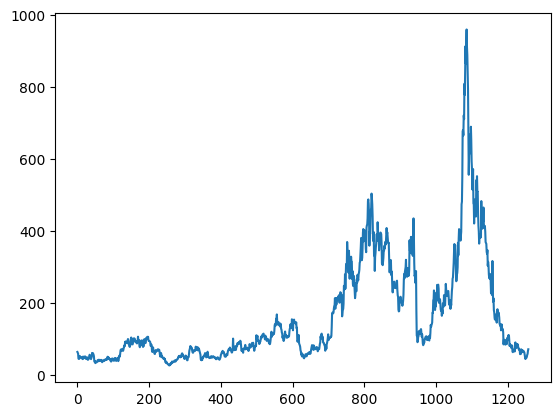

In [77]:
pd.Series(np.exp(decoder.predict([[np.random.random() for i in range(z_dim)]])[0].cumsum())*sp_data.iloc[-1,0]).plot()

Por otra parte, se podría pensar que podría haber algún tipo de "comportamiento implícito propio" de las acciones, de modo que unas acciones tenderán a moverse de una determinada manera. Si esto fuese así, no bastaría con generar nuevas series de precios a partir de vectores latentes "aleatorios", sino que se podría extraer la distribución normal que siguen los vectores latentes de cada una de las acciones, y generar un nuevo vector latente que siga esa distribución para generar futuros precios que, de algún modo "lleven implícito el comportamiento de la acción". Para desarrollar esta teoría, los pasos que se dan son los siguientes:

1. Decidir que serie de precios se quiere generar (de qué acción)
2. Estudiar la distribución del vector de dimensiones latentes de esa acción, tras pasar por el encoder
3. Generar un vector aleatorio de las dimensiones latentes, que siga la distribución del paso 2 (así se garantiza que la serie de precios generada tiene un comportamiento coherente)
4. Generar la nueva serie de precios a partir de la distribución del paso 3

El procedimiento anterior se podría realizar de la siguiente manera

In [136]:
def gen_prices(stock_num):
    lat_vec = encoder_mean.predict(x_train[stock_num:stock_num+1])[0]
    lat_vec = np.random.normal(lat_vec.mean(), lat_vec.std(), z_dim)
    new_prices = np.exp(decoder.predict([[_ for _ in lat_vec]])[0].cumsum())*sp_data.iloc[-1,stock_num]
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
    ax1.plot(np.array(sp_data.iloc[:,stock_num]));
    ax1.title.set_text('Serie de precios original')
    ax2.plot(new_prices);
    ax2.title.set_text('Nuevos precios')
    return

1/1 [==============================] - 0s 33ms/step


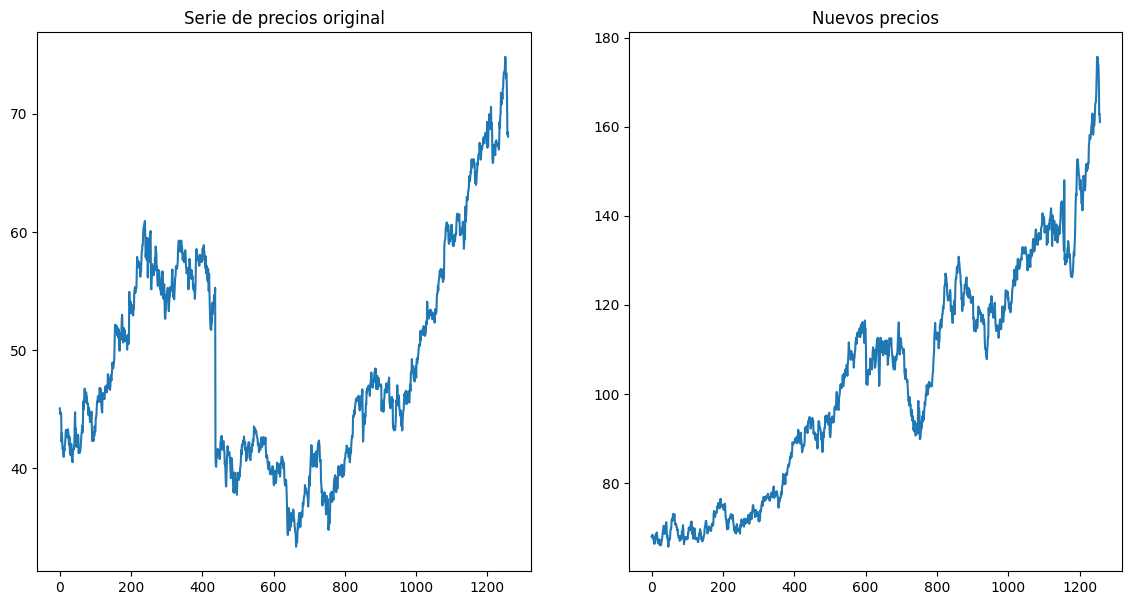

In [156]:
stock = 0
gen_prices(stock)

No obstante, como se ha visto, esto genera nuevas series de precios que tiendan a continuar la tendencia previa de la propia acción, generando menos movimientos bruscos de mercado que no se hayan dado en los datos originales.

Esto es así porque al fin y al cabo, se está generando un vector de dimensiones latentes "bastante similar" al vector de dimensiones latentes de la accion original, por lo que se se tenderá a replicar los movimientos de esa acción. Esto puede ser contraproducente a la hora de generar nuevos precios para poner a prueba algoritmos de inversión.


Nota: pese a que en muchas ocasiones los precios generados se parecen mucho a los precios antiguos, se ha de tener en cuenta que los movimientos partes de niveles de precios diferntes.